In [1]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
pd.options.mode.chained_assignment = None  
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import *
from datetime import datetime
from scipy.optimize import minimize
import yfinance as yf

from scipy.cluster.hierarchy import average, leaves_list, dendrogram,fcluster
from scipy.spatial.distance import squareform

## Data

In [2]:
#path = r'/Users/djomandanho/Documents/russell1000.csv'
path = 'russell1000.csv'
insample_start_date = '1990-01-01'
insample_end_date = '2000-01-01'
outsample_start_date = '2000-01-01'
outsample_end_date = '2010-01-01'

rebalancing_freq = '6M'

In [3]:
data = pd.read_csv(path)
data['index'] = pd.to_datetime(data['index'])
data = data.set_index("index")
data = np.exp(data) - 1 #convert to vanilla returns


df = data.loc[insample_start_date:outsample_end_date]
df = df.dropna(axis=1) #Keep only alive stocks in the index for this period

## Selecting Stocks by clustering

In [4]:
def sharpe_ratio(ts):
    return (ts.mean())/ts.std()

def stock_sr(sub_df):
    index = sharpe_ratio(sub_df).argmax()
    
    return sub_df.columns[index]

def select_stocks(df):
    
    distance = 1 - df.corr()

    avg  = average(squareform(distance))
    ordered_stocks = leaves_list(avg)
    
    threshold = 0.775
    labels = fcluster(avg, threshold, criterion='distance')

    # Show the cluster
    reg_corr = df.corr()
    dic = {}
    for i in set(labels):
        dic[i] = df.columns[labels==i]
    
    stocks = []
    for key,value in dic.items():
        stocks.append(stock_sr(df[value]))
        
    return stocks

In [5]:
selected_stocks = select_stocks(df.loc[insample_start_date:insample_end_date])
N = len(selected_stocks)
random_stocks = df.columns[:N]


df_insample = df.loc[insample_start_date:insample_end_date,random_stocks]
df_outsample = df.loc[outsample_start_date:outsample_end_date,random_stocks]
cov_matrix = df_insample.cov()
corr_matrix=df_insample.corr()

In [6]:
# data index russel
prices_russell = yf.download('^RUT', start=insample_start_date, end=outsample_end_date)['Adj Close']
df_russell = pd.DataFrame(prices_russell)

df_russell_insample = df_russell.loc[insample_start_date:insample_end_date]
df_russell_outsample = df_russell.loc[outsample_start_date:outsample_end_date]

df_russell_return = df_russell.pct_change().rename(columns={'Adj Close': 'return'})

russell_return_outsample = df_russell_return.loc[outsample_start_date:outsample_end_date]
print(df_russell_return)

[*********************100%***********************]  1 of 1 completed
              return
Date                
1990-01-02       NaN
1990-01-03  0.004943
1990-01-04 -0.004099
1990-01-05 -0.002587
1990-01-08 -0.000589
...              ...
2009-12-24  0.004897
2009-12-28 -0.000505
2009-12-29 -0.000899
2009-12-30  0.000363
2009-12-31 -0.012662

[5043 rows x 1 columns]


## Backtesting function

In [7]:
def backtest_strategy(dico_return): #dico_return{titre:df_return}
    
    facteur_annnualisation = 252
   
    
    ################   ptf_return .loc[row_indexer,col_indexer]
    dico_backtest = {}
    
    for titre,df_return in dico_return.items():
    
        start_date = df_return.index.min()
        end_date = df_return.index.max()

        df_return = df_return.dropna()
       
        df_return['cum_return'] = (1 + df_return['return']).cumprod() - 1

        total_return = df_return['cum_return'].iloc[-1] - 1  
        annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1

        dayly_volatility = df_return['return'].std()
        annualized_volatility = df_return['return'].std() * (facteur_annnualisation**0.5)

        sharpe_ratio = annualized_return / annualized_volatility

        cum_returns = (1 + df_return['return']).cumprod() - 1
        running_max = cum_returns.cummax()
        drawdown = cum_returns - running_max
        max_drawdown = drawdown.min()
        
        d = {"df_return":df_return,"start_date":start_date,"end_date":end_date,"total_return":total_return,"annualized_return":annualized_return,"dayly_volatility":dayly_volatility,"annualized_volatility":annualized_volatility,"sharpe_ratio":sharpe_ratio,"max_drawdown":max_drawdown}
        
        dico_backtest[titre] = d
    
    
        
    #################################################### Afficher les résultats
    print('      ############################## Backtesting ##############################')
    print()
    print(f'                         Start Date: {start_date}')
    print(f'                         End Date  : {end_date}')
    print(f'                         Nb jours  : {len(df_return)}')
    print()
    print()
    for titre,dico in dico_backtest.items():
        print(f'Total Return {titre}: {dico["total_return"]:.2%}                    Annualized Return {titre}: {dico["annualized_return"]:.2%}')
    print()
    for titre,dico in dico_backtest.items():
        print(f'Daily Volatility {titre}: {dico["dayly_volatility"]:.2%}                  Annualized Volatility {titre}: {dico["annualized_volatility"]:.2%}')
    
    print()
    for titre,dico in dico_backtest.items():
        print(f'Sharpe Ratio {titre}: {dico["sharpe_ratio"]:.2f}                    Max drawdown {titre}: {dico["max_drawdown"]:.2%}')
    print()
    
    ###################################################### Graphs
    
    plt.figure(figsize = (15,6))
    
    for titre,dico in dico_backtest.items():
        plt.plot(dico["df_return"]['cum_return'],lw=0.8,label=titre)
    
    """
    plt.fill_between(benchmark_return.index,benchmark_return['cum_return'], 0, where=(benchmark_return['cum_return'] >= 0), color='green', alpha=0.1)
    plt.fill_between(benchmark_return.index,benchmark_return['cum_return'], 0, where=(benchmark_return['cum_return'] <= 0), color='red', alpha=0.1)
    """
    
    plt.grid(alpha=0.4,linestyle='--')
    plt.title("Performance")
    plt.ylabel('Cumulative Returns (%)')
    plt.xticks(rotation=45)
    plt.legend()

    #################################### Returns
    plt.figure(figsize = (15,6))
    plt.subplot(121)
    
    for titre,dico in dico_backtest.items():
        plt.plot(dico["df_return"]['return'], "-o",label=titre)
    
    plt.title("Return")
    plt.grid(alpha=0.4,linestyle='--')
    plt.xticks(rotation=45)
    plt.legend()

    #################################### Hist Returns
    plt.subplot(122)
    for titre,dico in dico_backtest.items():
        plt.hist(dico["df_return"]['return'], bins=100,label=titre)
        
    plt.title("Distribution return strategy")
    plt.grid(alpha=0.4,linestyle='--')
    plt.legend()
    
    plt.show()

## Turnover analysis function

In [8]:
def turnover(list_date, list_poids):
    
    list_poids = np.array(list_poids)
   
    y = np.vstack(list_poids).T
    # plot
    fig, ax = plt.subplots(figsize=(8,4))
    ax.stackplot(list_date, y)
    plt.title("Turnover")
    plt.xlabel("time")
    plt.ylabel("weights")
    plt.show()

# 1- Robust Control 

## 1.1 - Static allocation

$$w_{rob}=argmax(\mu^{T}w-\kappa \sqrt{w^T\Omega w}-\frac{\lambda}{2} w^T \Sigma w)$$

$$s.t.  \sum_{i=1}^{N} w_{i}$$

In [9]:
# Define the objective function
def objective1(w):
    return - (mus @ w - kappa * np.sqrt(w @ omega @ w) - 0.5 * lambd * w @ S @ w)

def objective2(w,theta,w_previous):
    return - (mus @ w - kappa * np.sqrt(w @ omega @ w) - 0.5 * lambd * w @ S @ w - theta * np.linalg.norm((w - w_previous),1))

def robust_optimization(kappa,lambd,S,omega,mus,objective,*args):
    
    N = len(mus)
    
    #Initialize weights
    w0 = N * [1/N]

    # Define the bounds for w
    bounds = [(0, 1) for i in range(N)]

    # Define the constraints
    cons = [{'type': 'ineq', 'fun':lambda w: np.sum(w) - 1}]

    # Solve the optimization problem
    res = minimize(objective, w0, args=args,method='SLSQP', bounds=bounds,constraints=cons)
    return res.x.round(3)

### 1.1.1 Random stocks

In [10]:
kappa = 1
lambd = 13.3

S = cov_matrix.to_numpy()
omega = np.diag(S.diagonal(0,0,1))

mus = df_insample.mean()

w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective1)

insample_rob_perf = (1 + df_insample @ w_rob).cumprod() - 1
outsample_rob_perf = (1 + df_outsample @ w_rob).cumprod() - 1

insample_rob_return = df_insample @ w_rob
outsample_rob_return = df_outsample @ w_rob

In [11]:
ptf_return_rob_statique = pd.DataFrame(outsample_rob_return, columns=["return"])
ptf_return_rob_statique.index = pd.Index([d.date() for d in ptf_return_rob_statique.index])

### 1.1.3 Selected Stocks

In [12]:
df_insample = df.loc[insample_start_date:insample_end_date,selected_stocks]
df_outsample = df.loc[outsample_start_date:outsample_end_date,selected_stocks]
cov_matrix = df_insample.cov()
corr_matrix=df_insample.corr()



kappa = 1
lambd = 13.3

S = cov_matrix.to_numpy()
omega = np.diag(S.diagonal(0,0,1))

mus = df_insample.mean()

w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective1)

insample_rob_perf = (1 + df_insample @ w_rob).cumprod() - 1
outsample_rob_perf = (1 + df_outsample @ w_rob).cumprod() - 1

insample_rob_return_c = df_insample @ w_rob
outsample_rob_return_c = df_outsample @ w_rob

In [13]:
ptf_return_rob_statique_c = pd.DataFrame(outsample_rob_return_c, columns=["return"])
ptf_return_rob_statique_c.index = pd.Index([d.date() for d in ptf_return_rob_statique_c.index])

### 1.1.3 Backtest

      ############################## Backtesting ##############################

                         Start Date: 2000-01-03 00:00:00
                         End Date  : 2009-12-31 00:00:00
                         Nb jours  : 2515


Total Return Portfolio: robust static (random_stocks): 93.88%                    Annualized Return Portfolio: robust static (random_stocks): 6.86%
Total Return Portfolio: robust static (selected_stocks): 136.04%                    Annualized Return Portfolio: robust static (selected_stocks): 8.99%
Total Return Russel1000: -76.10%                    Annualized Return Russel1000: -13.36%

Daily Volatility Portfolio: robust static (random_stocks): 1.26%                  Annualized Volatility Portfolio: robust static (random_stocks): 19.97%
Daily Volatility Portfolio: robust static (selected_stocks): 1.38%                  Annualized Volatility Portfolio: robust static (selected_stocks): 21.84%
Daily Volatility Russel1000: 1.69%                  Annualize

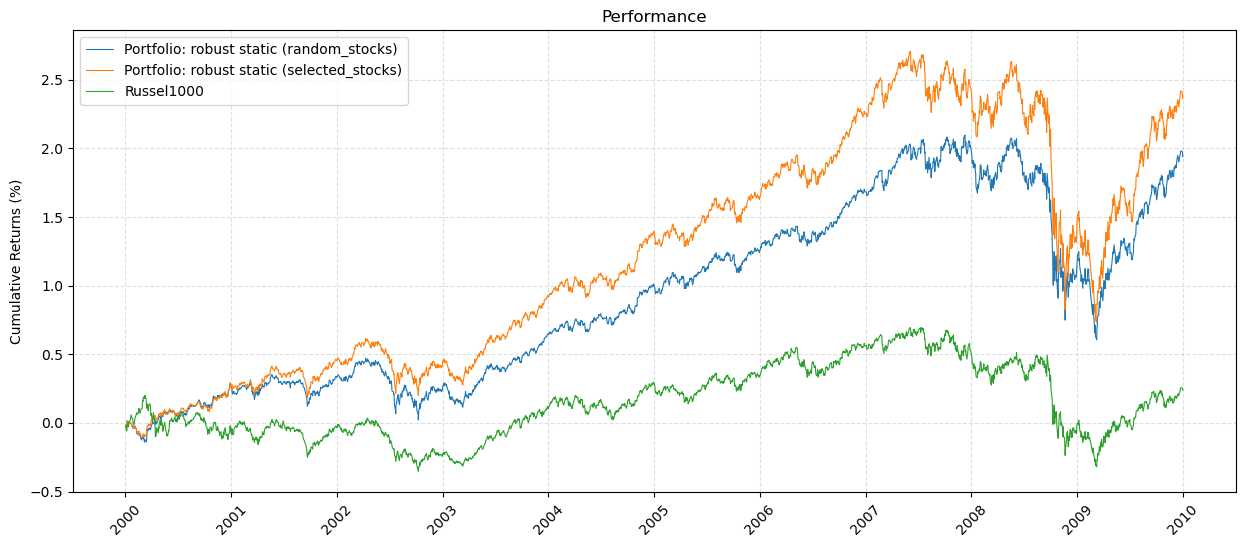

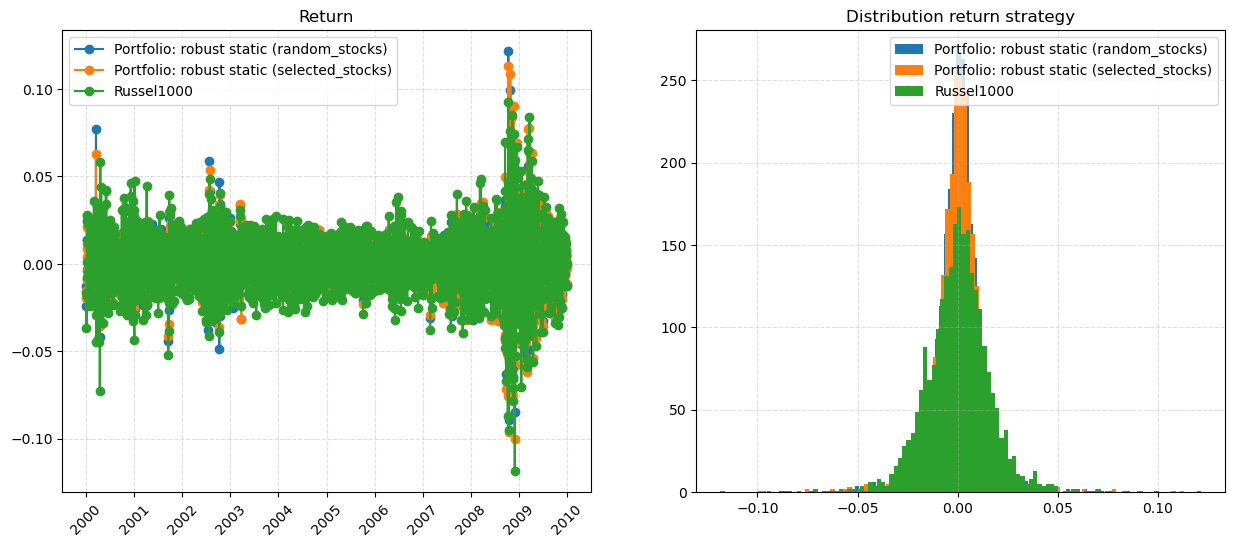

In [14]:
backtest_strategy({"Portfolio: robust static (random_stocks)":ptf_return_rob_statique,
                   "Portfolio: robust static (selected_stocks)":ptf_return_rob_statique_c,
                   "Russel1000":russell_return_outsample})

## 1.2 - Dynamic allocation

$$w_{rob}=argmax(\mu^{T}w-\kappa \sqrt{w^T\Omega w}-\frac{\lambda}{2} w^T \Sigma w - \sum_{i=1}^{N} |w - w_{previous}|)$$

### 1.2.1 Random Stocks

In [15]:
#https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases


start_date = outsample_start_date
end_date = outsample_end_date


df = data.loc[start_date:end_date].dropna(axis=1)

rebalancing_dates = pd.date_range(start=start_date, end=end_date,tz='UTC', freq=rebalancing_freq)
rebalancing_weights = [np.zeros(N)]
w_previous = rebalancing_weights[0]
c = 0.05 #transaction cost


kappa = 0.2
lambd = 0.5
theta = 1

In [16]:
# Loop through each rebalancing date
strategy_returns = pd.DataFrame(np.zeros(df.shape[0]),index=df.index,columns=['Returns'])

start_time = time.time()

for i,date in enumerate(rebalancing_dates[:-1]):
    
    current_data = df.loc[rebalancing_dates[i]:rebalancing_dates[i + 1]]
    current_date_range = current_data.index
    
    #stock selection
    stocks = random_stocks

    current_data = current_data[stocks]

    S = current_data.cov().to_numpy()
    mus = current_data.mean(axis=0)

    omega = np.diag(S.diagonal(0,0,1))

    #Optimize portfolio with aversion to turnover
    w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective2,theta,w_previous)
    
    returns = current_data.multiply(w_previous)
    
    strategy_returns.loc[current_date_range,'Returns'] = (current_data @ w_previous).values
    
    w_previous = w_rob
    
    rebalancing_weights.append(w_rob)
    print(i,':',date.strftime('%Y-%m-%d'),' ',rebalancing_dates[i + 1].strftime('%Y-%m-%d'),' ',sorted(w_rob)[::-1][:5])  

#Last period
current_data = df.loc[str(rebalancing_dates[-1]):] 
stocks = random_stocks
current_data = current_data[stocks]

strategy_returns.loc[str(rebalancing_dates[-1]):,'Returns'] = (current_data @ w_previous).values


print(f'Computing time : {time.time() - start_time:.2f}s')

0 : 2000-01-31   2000-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
1 : 2000-07-31   2001-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
2 : 2001-01-31   2001-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
3 : 2001-07-31   2002-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
4 : 2002-01-31   2002-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
5 : 2002-07-31   2003-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
6 : 2003-01-31   2003-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
7 : 2003-07-31   2004-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
8 : 2004-01-31   2004-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
9 : 2004-07-31   2005-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
10 : 2005-01-31   2005-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
11 : 2005-07-31   2006-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
12 : 2006-01-31   2006-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
13 : 2006-07-31   2007-01-31   [0.182, 0.169, 0.131, 0.095, 0.08]
14 : 2007-01-31   2007-07-31   [0.182, 0.169, 0.131, 0.095, 0.08]
15 : 2007-07-31   20

In [17]:
ptf_return_rob_dynamique = strategy_returns.rename(columns={'Returns': 'return'}).loc[outsample_start_date:outsample_end_date]
ptf_return_rob_dynamique.index = pd.Index([d.date() for d in ptf_return_rob_dynamique.index])

### 1.2.3 Selected stocks

In [18]:
## récuperation des données
start_date = outsample_start_date
end_date = outsample_end_date


df = data.loc[start_date:end_date].dropna(axis=1)

rebalancing_dates = pd.date_range(start=start_date, end=end_date,tz='UTC', freq=rebalancing_freq)
rebalancing_weights_c = [np.zeros(N)]
w_previous = rebalancing_weights_c[0]
c = 0.05 #transaction cost


kappa = 0.2
lambd = 0.5
theta = 1


In [19]:
# Loop through each rebalancing date
strategy_returns_c = pd.DataFrame(np.zeros(df.shape[0]),index=df.index,columns=['Returns'])

start_time = time.time()

for i,date in enumerate(rebalancing_dates[:-1]):
    
    current_data = df.loc[rebalancing_dates[i]:rebalancing_dates[i + 1]]
    current_date_range = current_data.index
    
    #stock selection
    stocks = selected_stocks

    current_data = current_data[stocks]

    S = current_data.cov().to_numpy()
    mus = current_data.mean(axis=0)

    omega = np.diag(S.diagonal(0,0,1))

    #Optimize portfolio with aversion to turnover
    w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective2,theta,w_previous)
    
    returns = current_data.multiply(w_previous)
    
    strategy_returns_c.loc[current_date_range,'Returns'] = (current_data @ w_previous).values
    
    w_previous = w_rob
    
    rebalancing_weights_c.append(w_rob)
    print(i,':',date.strftime('%Y-%m-%d'),' ',rebalancing_dates[i + 1].strftime('%Y-%m-%d'),' ',sorted(w_rob)[::-1][:5])  

#Last period
current_data = df.loc[str(rebalancing_dates[-1]):] 
stocks = selected_stocks
current_data = current_data[stocks]

strategy_returns_c.loc[str(rebalancing_dates[-1]):,'Returns'] = (current_data @ w_previous).values


print(f'Computing time : {time.time() - start_time:.2f}s')

0 : 2000-01-31   2000-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
1 : 2000-07-31   2001-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
2 : 2001-01-31   2001-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
3 : 2001-07-31   2002-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
4 : 2002-01-31   2002-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
5 : 2002-07-31   2003-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
6 : 2003-01-31   2003-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
7 : 2003-07-31   2004-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
8 : 2004-01-31   2004-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
9 : 2004-07-31   2005-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
10 : 2005-01-31   2005-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
11 : 2005-07-31   2006-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
12 : 2006-01-31   2006-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
13 : 2006-07-31   2007-01-31   [0.129, 0.116, 0.112, 0.097, 0.077]
14 : 2007-01-31   2007-07-31   [0.129, 0.116, 0.112, 0.097, 0.077]
15 : 

In [20]:
ptf_return_rob_dynamique_c = strategy_returns_c.rename(columns={'Returns': 'return'}).loc[outsample_start_date:outsample_end_date]
ptf_return_rob_dynamique_c.index = pd.Index([d.date() for d in ptf_return_rob_dynamique_c.index])

### 1.2.3 Backtest 

      ############################## Backtesting ##############################

                         Start Date: 2000-01-03
                         End Date  : 2009-12-31
                         Nb jours  : 2515


Total Return Portfolio: robust dynamic (random stocks): 90.64%                    Annualized Return Portfolio: robust dynamic (random stocks): 6.68%
Total Return Portfolio: robust dynamic(selected stocks): 44.01%                    Annualized Return Portfolio: robust dynamic(selected stocks): 3.72%
Total Return Russel1000: -76.10%                    Annualized Return Russel1000: -13.36%
Total Return Portfolio: robust static: 93.88%                    Annualized Return Portfolio: robust static: 6.86%

Daily Volatility Portfolio: robust dynamic (random stocks): 1.73%                  Annualized Volatility Portfolio: robust dynamic (random stocks): 27.49%
Daily Volatility Portfolio: robust dynamic(selected stocks): 1.59%                  Annualized Volatility Portfolio: r

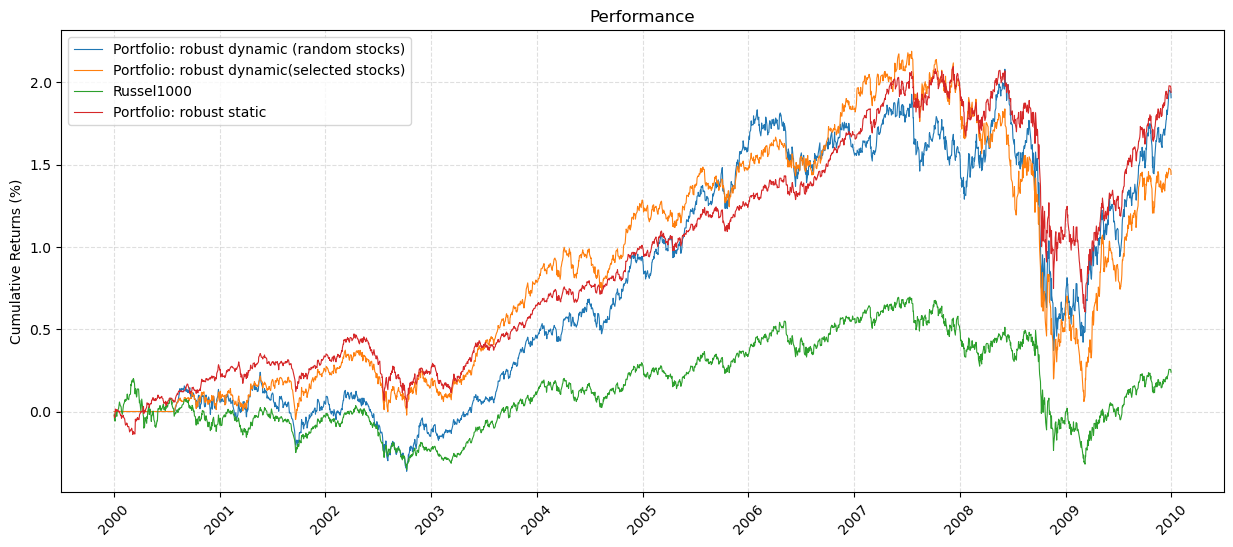

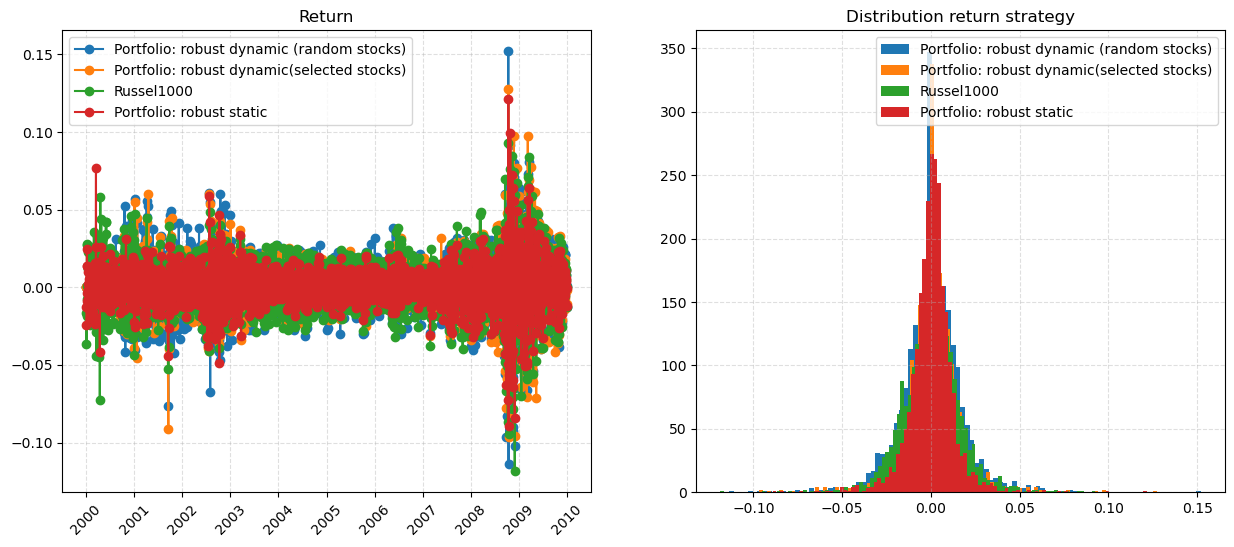

In [21]:
backtest_strategy({"Portfolio: robust dynamic (random stocks)":ptf_return_rob_dynamique,
                   "Portfolio: robust dynamic(selected stocks)":ptf_return_rob_dynamique_c,
                   "Russel1000":russell_return_outsample,"Portfolio: robust static":ptf_return_rob_statique})

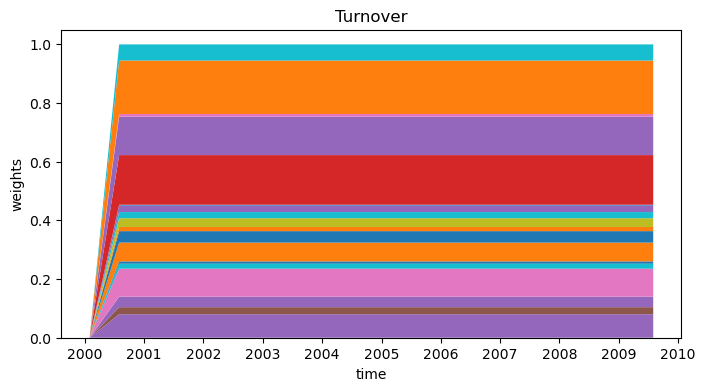

In [22]:
##################################### Plot turnover #######################
#print(len(np.vstack(rebalancing_weights).T)
turnover(rebalancing_dates, rebalancing_weights)

# 2- Covariance Matrix Filtering

### Clipping Method

In [23]:
#define lambdamax used for the clipping
def lamda_max(N,T,sigma):
    return (sigma**2) * (1 + N/T + 2*np.sqrt(N/T))


# Compute the clipping correlation matrix
def corr_clipping (N,T,corr_matrix):
    
    """Clipping based on correlation matrix"""
    #sigma_clipping = 1
    eigenvalues,eigenvector = np.linalg.eig(corr_matrix)
    sigma_clipping = 1-max(eigenvalues)/N
    lamdamax = lamda_max(N, T, sigma_clipping)
    small_eigenvalues = np.array([elem for elem in eigenvalues if elem < lamdamax ])
    mean_small= np.mean(small_eigenvalues)
    diag_clipping = np.diag([elem if elem > lamdamax else mean_small for elem in eigenvalues])
    corr_clipping = eigenvector.T @ diag_clipping @ eigenvector
    
    return corr_clipping


# Compute the clipping covariance matrix
def cov_clipping(N,T,corr_matrix,var_matrix):
    
    # calculation of the adjusted corrclipping coefficient
    corrclipping = corr_clipping(N,T, corr_matrix)
    diag_corrclipping = np.diag(np.diag(corrclipping))
    diag_corrclipping_inv = np.linalg.inv(diag_corrclipping)
    corrclipping_adj = diag_corrclipping_inv @ corrclipping @ diag_corrclipping_inv
    covclipping = np.sqrt(var_matrix) @ corrclipping_adj @ np.sqrt(var_matrix)
    
    return covclipping

###  Cross Validation

In [24]:
#using cross validation

def lambdaCV(data, index_in_list,index_out_list):
    
    #return the lambda_CV for only one cross validation
    data_in = data.iloc[index_in_list]
    data_out = data.iloc[index_out_list]
    cov_matrix_in = np.cov(data_in.T, bias=True)
    cov_matrix_out = np.cov(data_out.T, bias=True)
    eigenvalues_in,eigenvectors_in = np.linalg.eig(cov_matrix_in)
    lambdaCV = eigenvectors_in.T @ cov_matrix_out @ eigenvectors_in
    
    return np.diag(lambdaCV)

def lambda_CV_moy(nbCV,data):
    
    #applied on the insample data for nbCV Cross validation:
    
    lambda_list = []
    size_in_CV = int(0.7*data.shape[0])
    listdata = range(data.shape[0])
    
    for i in range(nbCV):
        index_in_list = rd.sample(listdata,size_in_CV)
        index_out_list =[elem for elem in listdata if not elem in index_in_list]
        lambda_CV = lambdaCV(data, index_in_list, index_out_list)
        lambda_list.append(lambda_CV)
        
    lambda_list=np.array(lambda_list)
    data_CV=pd.DataFrame(lambda_list)
        
    return np.array(data_CV.mean(axis=0))


def lambda_CV_iso(nbCV,data):
    
    #Computation of lambda_in
    cov_matrix = np.cov(data.T, bias=True)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    
    #Retrieval of lambda_Cross validation
    lambdaCross = lambda_CV_moy(nbCV,data)
    iso_reg = IsotonicRegression().fit(eigenvalues,lambdaCross )
    lambda_iso=np.diag(iso_reg.predict(eigenvalues))
    
    return lambda_iso, eigenvalues, eigenvectors
        
def cov_matrix_CV(data,nbCV=100):
    lambda_iso, eigenvalues, eigenvectors = lambda_CV_iso(nbCV,data)
    cov_CV= eigenvectors @ lambda_iso @ eigenvectors.T
    return cov_CV

###  Markowitz Optimisation

In [25]:
def markowitz_optimization(objective,*args):
    
    N = len(mus)
    
    #Initialize weights
    w0 = N * [1/N]

    # Define the bounds for w
    bounds = [(0, 1) for i in range(N)]

    # Define the constraints
    cons = [{'type': 'eq', 'fun':lambda w: np.sum(w) - 1}]

    # Solve the optimization problem
    res = minimize(objective, w0, args=args,method='SLSQP', bounds=bounds,constraints=cons)
    return res.x.round(3)

#Objective Function used for Markowitz optimisation

#def objective3(w):
#    return - (mus @ w - 0.5 * lambd * w @ S @ w)

def objective3(w,Sigma,mu,lambd):
    return - (mu @ w - 0.5 * lambd * w @ Sigma @ w)

In [26]:
def getweights(data,objective,lambd,method="clipping"):
    N = len(stocks)
    T= len(data.index)
    mu = data.mean()
    if method == "clipping":
        cov = data.cov().to_numpy()
        corr= data.corr().to_numpy()
        var_matrix=np.diag(np.diag(cov))
        Sigma = cov_clipping(N,T,corr,var_matrix)
    if method == "cv":
        Sigma = cov_matrix_CV(data)
        
    w= markowitz_optimization(objective,Sigma,mu,lambd)
    return w

def getweights_dynamic(data,objective,lambd,c,wprevious,method="clipping"):
    N = len(stocks)
    T= len(data.index)
    mu = data.mean()
    if method == "clipping":
        cov = data.cov().to_numpy()
        corr= data.corr().to_numpy()
        var_matrix=np.diag(np.diag(cov))
        Sigma = cov_clipping(N,T,corr,var_matrix)
    if method == "cv":
        Sigma = cov_matrix_CV(data)
        
    w= markowitz_optimization(objective,Sigma,mu,lambd,c,wprevious)
    return w
def getreturns(data_in,data_out,objective,lambd,method="clipping"):
    w = getweights(data_in,objective,lambd,method=method)
    returns = data_out @ w
    return returns

## 2.1 - Static Allocation

In [27]:
df = data.loc[insample_start_date:outsample_end_date].dropna(axis=1)

### 2.1.1 Random stocks

In [28]:
## data random stocks
df_insample = df.loc[insample_start_date:insample_end_date,random_stocks]
df_outsample = df.loc[outsample_start_date:outsample_end_date,random_stocks]

lambd = 13.3


# Compute Clipping weights

w_clipping = getweights(df_insample,objective3,lambd,method="clipping")
w_cv = getweights(df_insample,objective3,lambd,method="cv")

#Cumulative Return

insample_clipping_perf = (1 + df_insample @ w_clipping).cumprod() - 1
outsample_clipping_perf = (1 + df_outsample @ w_clipping).cumprod() - 1

insample_cv_perf = (1 + df_insample @ w_cv).cumprod() - 1
outsample_cv_perf = (1 + df_outsample @ w_cv).cumprod() - 1


insample_clipping_return = df_insample @ w_clipping
outsample_clipping_return = df_outsample @ w_clipping


insample_cv_return = df_insample @ w_cv
outsample_cv_return = df_outsample @ w_cv

In [29]:
ptf_return_clipping_statique = pd.DataFrame(outsample_clipping_return, columns=["return"])
ptf_return_clipping_statique.index = pd.Index([d.date() for d in ptf_return_clipping_statique.index])

In [30]:
ptf_return_cv_statique = pd.DataFrame(outsample_cv_return, columns=["return"])
ptf_return_cv_statique.index = pd.Index([d.date() for d in ptf_return_cv_statique.index])

### 2.1.2 Selected Stocks

In [31]:
## data selected stocks
df_insample = df.loc[insample_start_date:insample_end_date,selected_stocks]
df_outsample = df.loc[outsample_start_date:outsample_end_date,selected_stocks]

# Compute Clipping weights

w_clipping = getweights(df_insample,objective3,lambd,method="clipping")
w_cv = getweights(df_insample,objective3,lambd,method="cv")

#Cumulative Return

insample_clipping_perf = (1 + df_insample @ w_clipping).cumprod() - 1
outsample_clipping_perf = (1 + df_outsample @ w_clipping).cumprod() - 1

insample_cv_perf = (1 + df_insample @ w_cv).cumprod() - 1
outsample_cv_perf = (1 + df_outsample @ w_cv).cumprod() - 1


insample_clipping_return_c = df_insample @ w_clipping
outsample_clipping_return_c = df_outsample @ w_clipping


insample_cv_return_c = df_insample @ w_cv
outsample_cv_return_c = df_outsample @ w_cv

In [32]:
ptf_return_clipping_statique_c = pd.DataFrame(outsample_clipping_return_c, columns=["return"])
ptf_return_clipping_statique_c.index = pd.Index([d.date() for d in ptf_return_clipping_statique_c.index])

ptf_return_cv_statique_c = pd.DataFrame(outsample_cv_return_c, columns=["return"])
ptf_return_cv_statique_c.index = pd.Index([d.date() for d in ptf_return_cv_statique_c.index])

### 2.1.3 Backtest

      ############################## Backtesting ##############################

                         Start Date: 2000-01-03 00:00:00
                         End Date  : 2009-12-31 00:00:00
                         Nb jours  : 2515


Total Return Portfolio: clipping static(random stocks): 6.15%                    Annualized Return Portfolio: clipping static(random stocks): 0.60%
Total Return Portfolio: CV static(random stocks): 44.00%                    Annualized Return Portfolio: CV static(random stocks): 3.72%
Total Return Portfolio: clipping static (selected stocks): 29.97%                    Annualized Return Portfolio: clipping static (selected stocks): 2.66%
Total Return Portfolio: CV static (selected stocks): 43.49%                    Annualized Return Portfolio: CV static (selected stocks): 3.68%
Total Return Russel1000: -76.10%                    Annualized Return Russel1000: -13.36%

Daily Volatility Portfolio: clipping static(random stocks): 1.83%                  Annu

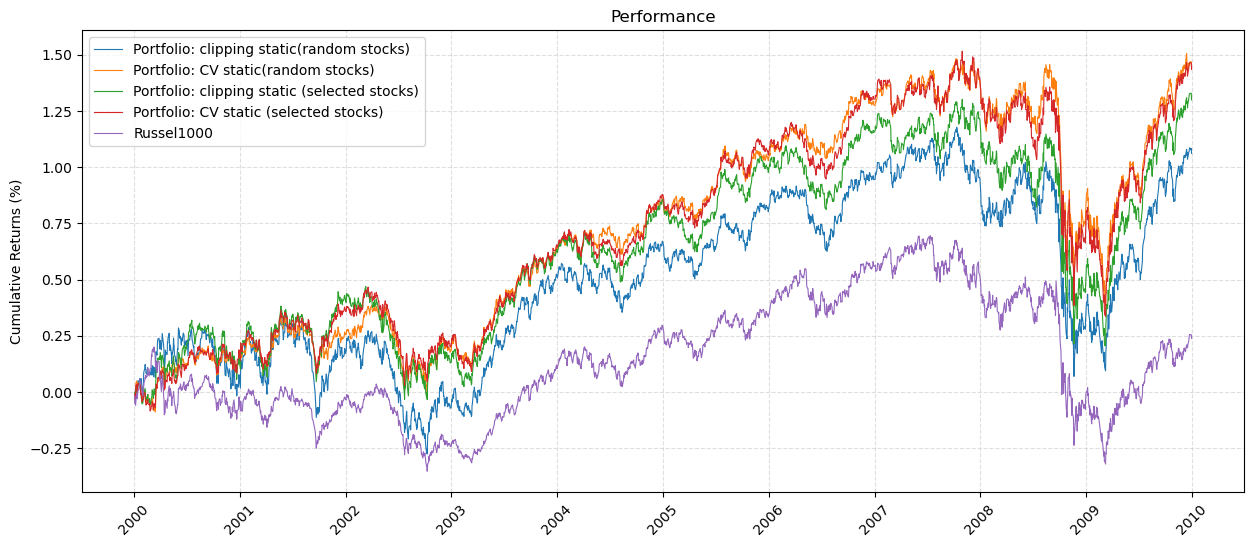

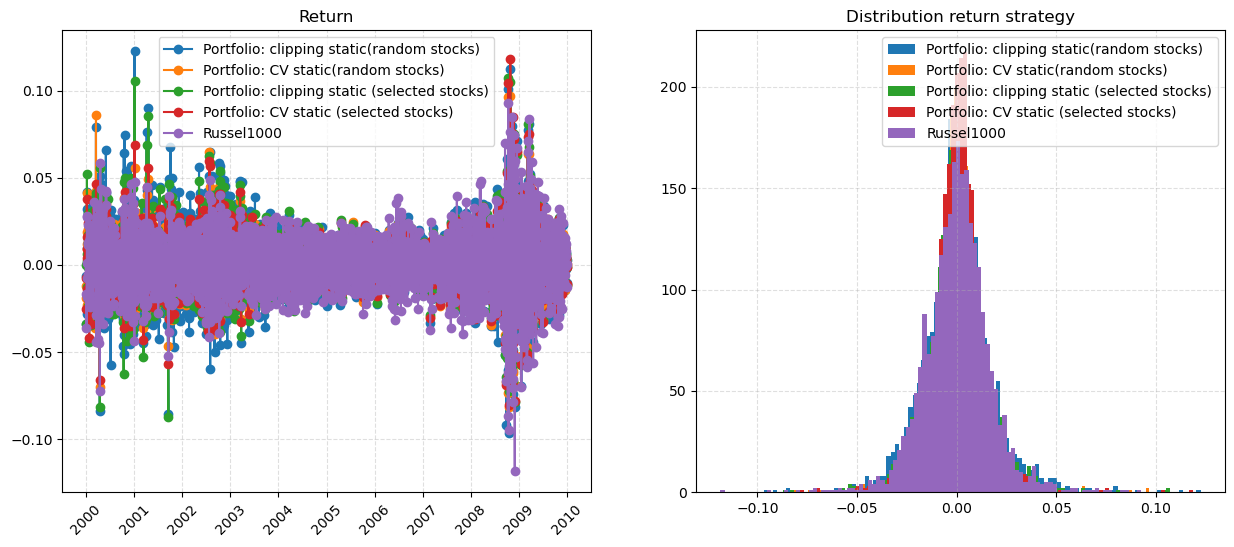

In [33]:
backtest_strategy({"Portfolio: clipping static(random stocks)":ptf_return_clipping_statique,
                   "Portfolio: CV static(random stocks)":ptf_return_cv_statique,
                   "Portfolio: clipping static (selected stocks)":ptf_return_clipping_statique_c,
                   "Portfolio: CV static (selected stocks)":ptf_return_cv_statique_c,
                   "Russel1000":russell_return_outsample})

## 2.2 - Dynamic allocation

$$w_{MVO}=argmax(\mu^{T}w-\frac{\lambda}{2} w^T \Sigma w - c\sum_{i=1}^{N} |w - w_{previous}|)$$

In [34]:
def dynamic_allocation(data,start_in,end_in,start_out,end_out,rebalancing_freq, objective,objective_cost,lambd,
                       stocks,c,method= "clipping"):
     
    new_data_list =[]
    start_data_in = pd.to_datetime(start_in).tz_localize(tz='UTC')
    end_data_in = pd.to_datetime(end_in).tz_localize('UTC')
    #T= datetime.strptime(end_data_in,"%Y-%M-%d") - datetime.strptime(start_data_in,"%Y-%M-%d")
    T = end_data_in - start_data_in
    start_data_out = pd.to_datetime(start_out).tz_localize('UTC')
    end_data_out = pd.to_datetime(end_out).tz_localize('UTC')
    rebalancing_dates_range = pd.date_range(start=start_out,end=end_out,tz='UTC',freq=rebalancing_freq)
    
    list_weights = []
    
    for i,date in enumerate(rebalancing_dates_range):
        current_data_in = data.loc[start_data_in:end_data_in,:].dropna(axis=1)
        current_data_out= data.loc[start_data_out:rebalancing_dates_range[i],:]
        #Selections of stocks
        #stocks = current_data_in.columns[:N]
        current_data_in =current_data_in [stocks]
        current_data_out= current_data_out[stocks]
        if i==0:
            w= getweights(current_data_in,objective,lambd,method=method)
        else:
            w= getweights_dynamic(current_data_in,objective_cost,lambd,c,wprevious,method=method)
            
        returns= current_data_out @ w
        wprevious=w
        #returns= getreturns(current_data_in,current_data_out,objective_cost,lambd,method=method)
        new_data_list.append(returns)
        end_data_in = rebalancing_dates_range[i]
        start_data_in = end_data_in-T
        start_data_out = end_data_in
        #start_data_in = datetime.strftime(start_data_in,"%Y-%M-%d")
        
        list_weights.append(w)
    return (pd.concat(new_data_list)), list_weights, rebalancing_dates_range

In [35]:
c=0.5

In [36]:
def objective4(w,Sigma,mu,lambd,c,w_previous):
    return - (mu @ w  - 0.5 * lambd * w @ Sigma @ w - theta * np.linalg.norm((w - w_previous),1))



### 2.3.1 Random stocks

In [37]:
rendements_clipping, list_weights_clipping, rebalancing_dates_range  = dynamic_allocation(data,insample_start_date,insample_end_date,outsample_start_date,outsample_end_date,
                                                                                          rebalancing_freq,objective3,objective4,lambd, random_stocks,c,method= "clipping")
rendements_clipping

index
2000-01-03 05:00:00+00:00   -0.006442
2000-01-04 05:00:00+00:00   -0.034218
2000-01-05 05:00:00+00:00   -0.008065
2000-01-06 05:00:00+00:00    0.009938
2000-01-07 05:00:00+00:00    0.041609
                               ...   
2009-07-24 04:00:00+00:00    0.007902
2009-07-27 04:00:00+00:00    0.000956
2009-07-28 04:00:00+00:00    0.008236
2009-07-29 04:00:00+00:00   -0.000173
2009-07-30 04:00:00+00:00    0.007604
Length: 2408, dtype: float64

In [38]:
#N=100

rendements_cv,list_weights_cv, rebalancing_dates_range = dynamic_allocation(data,insample_start_date,insample_end_date,outsample_start_date,outsample_end_date,
                                                                             rebalancing_freq,objective3,objective4,lambd, random_stocks,c,method= "cv")


In [39]:
ptf_return_cv_dynamique = pd.DataFrame(rendements_cv, columns=["return"])
ptf_return_cv_dynamique.index = pd.Index([d.date() for d in ptf_return_cv_dynamique.index])

ptf_return_clipping_dynamique = pd.DataFrame(rendements_clipping, columns=["return"])
ptf_return_clipping_dynamique.index = pd.Index([d.date() for d in ptf_return_clipping_dynamique.index])


### 2.3.2 Selected Stocks

In [40]:
rendements_clipping_c, list_weights_clipping_c, rebalancing_dates_range  = dynamic_allocation(data,insample_start_date,insample_end_date,outsample_start_date,outsample_end_date,
                                                                                          rebalancing_freq,objective3,objective4,lambd, selected_stocks,c,method= "clipping")
rendements_clipping_c

index
2000-01-03 05:00:00+00:00   -0.000367
2000-01-04 05:00:00+00:00   -0.033730
2000-01-05 05:00:00+00:00    0.006124
2000-01-06 05:00:00+00:00    0.000713
2000-01-07 05:00:00+00:00    0.052054
                               ...   
2009-07-24 04:00:00+00:00   -0.008911
2009-07-27 04:00:00+00:00   -0.001809
2009-07-28 04:00:00+00:00    0.011759
2009-07-29 04:00:00+00:00    0.002735
2009-07-30 04:00:00+00:00    0.010362
Length: 2408, dtype: float64

In [41]:
#N=100

rendements_cv_c,list_weights_cv_c, rebalancing_dates_range = dynamic_allocation(data,insample_start_date,insample_end_date,outsample_start_date,outsample_end_date,
                                                                             rebalancing_freq,objective3,objective4,lambd, selected_stocks,c,method= "cv")


In [42]:
ptf_return_cv_dynamique_c = pd.DataFrame(rendements_cv_c, columns=["return"])
ptf_return_cv_dynamique_c.index = pd.Index([d.date() for d in ptf_return_cv_dynamique_c.index])

ptf_return_clipping_dynamique_c = pd.DataFrame(rendements_clipping_c, columns=["return"])
ptf_return_clipping_dynamique_c.index = pd.Index([d.date() for d in ptf_return_clipping_dynamique_c.index])


## Backtesting

      ############################## Backtesting ##############################

                         Start Date: 2000-01-03 00:00:00
                         End Date  : 2009-12-31 00:00:00
                         Nb jours  : 2515


Total Return Portfolio: clipping dynamique (Random Stocks): -22.96%                    Annualized Return Portfolio: clipping dynamique (Random Stocks): -2.69%
Total Return Portfolio: CV dynamique (Random Stocks): 15.75%                    Annualized Return Portfolio: CV dynamique (Random Stocks): 1.54%
Total Return Portfolio: clipping dynamique (Selected Stocks): -1.12%                    Annualized Return Portfolio: clipping dynamique (Selected Stocks): -0.12%
Total Return Portfolio: CV dynamique (Selected Stocks): 10.09%                    Annualized Return Portfolio: CV dynamique (Selected Stocks): 1.01%
Total Return Russel1000: -76.10%                    Annualized Return Russel1000: -13.36%

Daily Volatility Portfolio: clipping dynamique (Random 

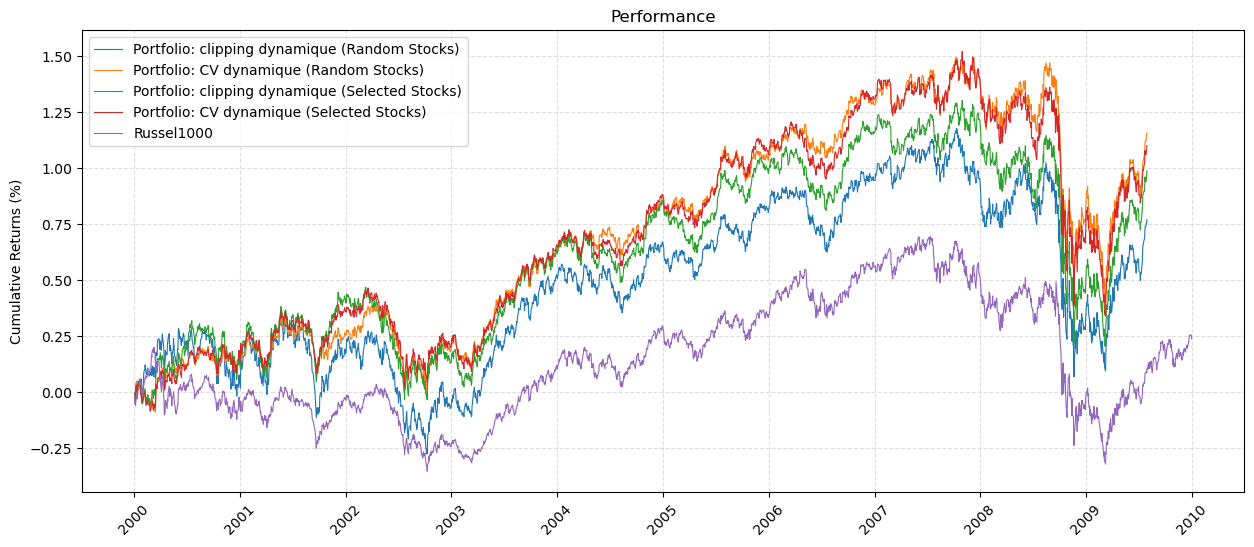

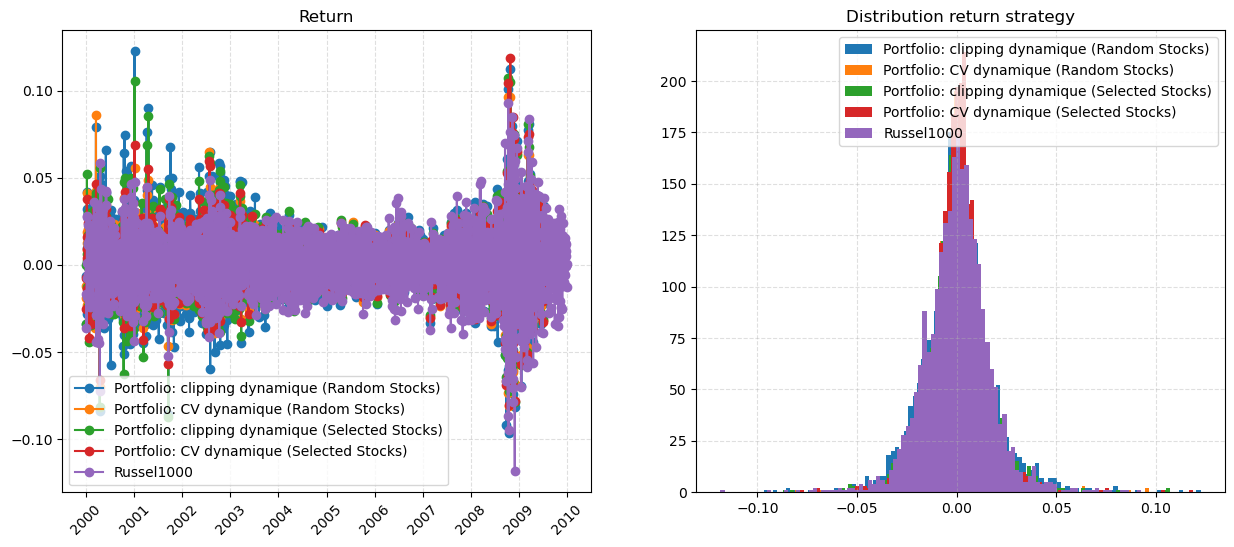

In [43]:
backtest_strategy({"Portfolio: clipping dynamique (Random Stocks)":ptf_return_clipping_dynamique,
                   "Portfolio: CV dynamique (Random Stocks)":ptf_return_cv_dynamique,
                   "Portfolio: clipping dynamique (Selected Stocks)":ptf_return_clipping_dynamique_c,
                   "Portfolio: CV dynamique (Selected Stocks)":ptf_return_cv_dynamique_c,
                   "Russel1000":russell_return_outsample})

## Turnover

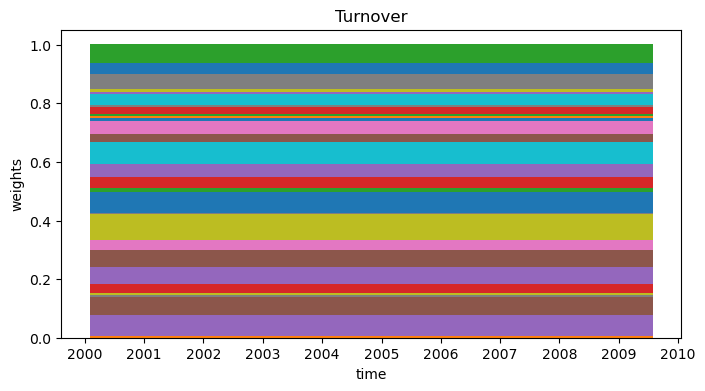

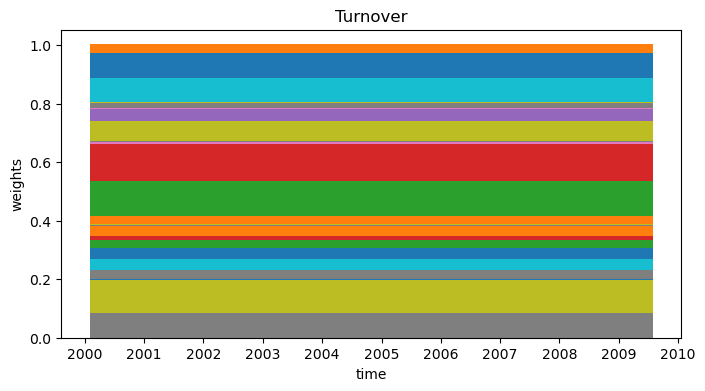

In [44]:
######################## Clipping #######################
turnover(rebalancing_dates_range, list_weights_clipping)

turnover(rebalancing_dates_range, list_weights_clipping_c)


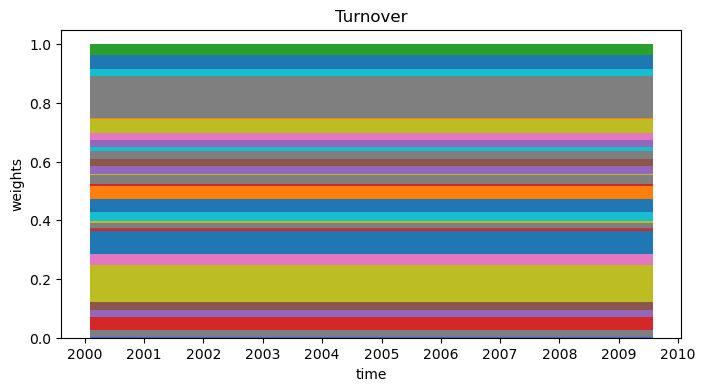

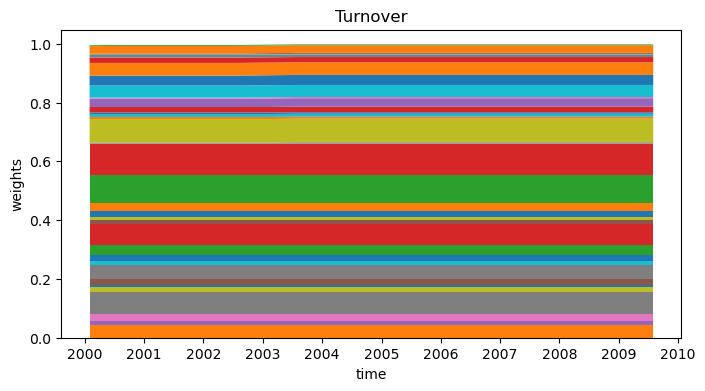

In [45]:
######################## CV #######################
turnover(rebalancing_dates_range, list_weights_cv)

turnover(rebalancing_dates_range, list_weights_cv_c)

## Autres

In [46]:
tret = 0.2
mu = df_insample.mean()

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: tret - mu @ x})

bnds = tuple((0, 1) for x in range(N))
eweights = np.array(N * [1. / N,])

opts = minimize(risk_Portfolio,eweights,args=(cov_matrix),method='SLSQP', bounds=bnds,constraints=cons)

w = opts['x'].round(3)

ticker = df_insample.columns[np.where(w==1)]

NameError: name 'risk_Portfolio' is not defined

In [ ]:
list_mu_p, vol, weights, mu_GMV, mu_MSR, vol_GMV, vol_MSR, w_GMV, w_MSR = efficient_frontier(df_insample, method= "classic")

In [ ]:
prtfs = pd.DataFrame({'ret':list_mu_p,'vol':vol})
prtfs['sharpe'] = prtfs['ret'] / prtfs['vol']
w_MSR = prtfs[prtfs['sharpe'] == prtfs['sharpe'].max()][['ret','vol']].values.reshape(-1)

In [ ]:
mu = df_insample.mean()

In [ ]:
list_mu_p = list(np.linspace(0,0.2,100))
    
weights = [weights_optimal(mu_p, mu, cov_matrix) for mu_p in list_mu_p]

In [ ]:
vols = [risk_Portfolio(w, cov_matrix) / 252 for w in weights]

In [ ]:
plt.plot(vols,list_mu_p)

In [ ]:
w_GMV = weights_GMV(cov_matrix)
w_MSR = weights_MSR(mu,cov_matrix)

In [ ]:
w_GMV

In [ ]:
# Compute of the optimal weights for each expected return
weights = np.array([weights_optimal(mu_p, mu, cov_matrix) for mu_p in list_mu_p])
w_GMV = weights_GMV(cov_matrix)
w_MSR = weights_MSR(mu,cov_matrix)

list_mu_p = np.array([252*mu_p for mu_p in list_mu_p ])

# Compute of the associated risk
vol = np.array([risk_Portfolio(w,cov_matrix) for w in weights])
vol_GMV = risk_Portfolio(w_GMV, cov_matrix)
vol_MSR = risk_Portfolio(w_MSR, cov_matrix)

mu_GMV = w_GMV @ mu
mu_MSR = w_MSR @ mu

In [ ]:
list_mu_p = list(np.linspace(0,2.5,100)/252)

# Compute of the optimal weights for each expected return
weights = np.array([weights_optimal(mu_p, mu, cov_matrix) for mu_p in list_mu_p])
w_GMV = weights_GMV(cov_matrix)
w_MSR = weights_MSR(mu,cov_matrix)

list_mu_p = np.array([252*mu_p for mu_p in list_mu_p ])

# Compute of the associated risk
vol = np.array([risk_Portfolio(w,cov_matrix) for w in weights])
vol_GMV = risk_Portfolio(w_GMV, cov_matrix)
vol_MSR = risk_Portfolio(w_MSR, cov_matrix)

mu_GMV = w_GMV @ mu
mu_MSR = w_MSR @ mu

In [ ]:
plt.plot(vol,list_mu_p)
plt.scatter(vol_MSR,mu_MSR,s=250,color='red')
plt.scatter(vol_GMV,mu_GMV,s=250,color='green')
plt.scatter(w_MSR[0],w_MSR[1],s=250,color='pink')
plt.show()

## Results

In [ ]:
rob_rets = df_outsample @ w_rob
rob_perf = (1 + rob_rets).cumprod() - 1

clean_rets = df_outsample @ w_clean
clean_perf = (1 + clean_rets).cumprod() - 1

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(rob_perf)
plt.plot(clean_perf)

plt.ylabel('Cumulative Return (%)')
plt.show()